In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageEnhance 
import random

# RETFOUND
# https://www.nature.com/articles/s41586-023-06555-x
# https://github.com/rmaphoh/RETFound_MAE

In [2]:
import models_vit
from pos_embed import interpolate_pos_embed
from timm.models.layers import trunc_normal_

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
model = models_vit.__dict__['vit_large_patch16'](
    num_classes=3,
    drop_path_rate=0.2,
    global_pool=False,
).to(device)

# model.load_state_dict(torch.load("4_epochs", weights_only=True))

In [6]:
# call the model
model = models_vit.__dict__['vit_large_patch16'](
    num_classes=3,
    drop_path_rate=0.2,
    global_pool=False,
).to(device)

# load RETFound weights
checkpoint = torch.load('RETFound_cfp_weights.pth', map_location=device)
checkpoint_model = checkpoint['model']
state_dict = model.state_dict()
for k in ['head.weight', 'head.bias']:
    if k in checkpoint_model and checkpoint_model[k].shape != state_dict[k].shape:
        print(f"Removing key {k} from pretrained checkpoint")
        del checkpoint_model[k]

# interpolate position embedding
interpolate_pos_embed(model, checkpoint_model)

# load pre-trained model
msg = model.load_state_dict(checkpoint_model, strict=False)

# assert set(msg.missing_keys) == {'head.weight', 'head.bias', 'fc_norm.weight', 'fc_norm.bias'}

# manually initialize fc layer
# trunc_normal_(model.head.weight, std=2e-5)

print("Model = %s" % str(model))

Model = VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (n

In [8]:
x = torch.randn(1, 3, 224, 224).to(device)
output = model(x)
print(output)
print(nn.Softmax(dim=1)(output))

tensor([[ 0.4057, -0.1891, -0.1014]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[0.4643, 0.2561, 0.2796]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


In [5]:
def change_contrast(img, level):
    factor = (259 * (level + 255)) / (255 * (259 - level))
    def contrast(c):
        value = 128 + factor * (c - 128)
        return max(0, min(255, value))
    return img.point(contrast)

def image_loader(image_path, rotation=0, image_size = 224): # Image, GroundTruths
    
    rotation = random.randint(0, 360)
    contrast = random.randint(0, 25)
     
    
    try:
        im = Image.open(image_path)
        im = im.rotate(rotation)
        im = change_contrast(im, contrast)
        
        if np.mean(im) < 30:
            im3 = ImageEnhance.Brightness(im)
            im = im3.enhance(2)
            
        elif np.mean(im) < 40:
            im3 = ImageEnhance.Brightness(im)
            im = im3.enhance(1.5)
        
        im = im.resize((image_size,image_size))
        im = torchvision.transforms.functional.pil_to_tensor(im).reshape([1,3,image_size,image_size])
        im = im / 255
        
        return im

    except FileNotFoundError:
        return False
    
def batch_loader(image_paths, truths, img_size=224):
    
    train_x = torch.zeros(0, 3, img_size, img_size)
    train_y = torch.zeros(0, 3)
    
    for i in range(0, len(image_paths)):
        x = image_loader(image_paths[i], image_size = img_size)
        y = truths[i]
        
        if x is not False:
            train_x = torch.cat((train_x, x), 0)
            train_y = torch.cat((train_y, y), 0)
            
    return train_x, train_y
        


In [6]:
Shanghai = "Datasets/Shanghai HR/HRDC Hypertensive Retinopathy Classification Training Labels.csv"
ODIR = "Datasets/ODIR/full_df.csv"
messidor = "Datasets/messidor-2 DR/messidor_data.csv"

In [7]:
image_list = []
ground_truth_list = []

df_shanghai = pd.read_csv(Shanghai)
df_odir = pd.read_csv(ODIR)
df_messidor = pd.read_csv(messidor)

# ODIR
n=0
for img in range(0, df_odir.shape[0]): # ODIR - LEFT
    
    if df_odir['Left-Diagnostic Keywords'][n] == 'normal fundus':
        image_list.append("Datasets/ODIR/preprocessed_images/" + df_odir['Left-Fundus'][img])
        ground_truth_list.append(torch.tensor([[1.0, 0.0, 0.0]]))
        
    elif sum([df_odir["N"][n], df_odir["D"][n], df_odir["H"][n]]) == 1:
        if 'diabetic' in df_odir['Left-Diagnostic Keywords'][n]:
            image_list.append("Datasets/ODIR/preprocessed_images/" + df_odir['Right-Fundus'][img])
            ground_truth_list.append(torch.tensor([[0.0, 1.0, 0.0]]))
            
        elif 'hyper' in df_odir['Left-Diagnostic Keywords'][n]:
            image_list.append("Datasets/ODIR/preprocessed_images/" + df_odir['Right-Fundus'][img])
            ground_truth_list.append(torch.tensor([[0.0, 0.0, 1.0]]))
 
    n+=1
    
n=0
for img in range(0, df_odir.shape[0]): # ODIR - RIGHT
    
    if df_odir['Right-Diagnostic Keywords'][n] == 'normal fundus':
        image_list.append("Datasets/ODIR/preprocessed_images/" + df_odir['Right-Fundus'][img])
        ground_truth_list.append(torch.tensor([[1.0, 0.0, 0.0]]))
        
    elif sum([df_odir["N"][n], df_odir["D"][n], df_odir["H"][n]]) == 1:
        if 'diabetic' in df_odir['Right-Diagnostic Keywords'][n]:
            image_list.append("Datasets/ODIR/preprocessed_images/" + df_odir['Right-Fundus'][img])
            ground_truth_list.append(torch.tensor([[0.0, 1.0, 0.0]]))
            
        elif 'hyper' in df_odir['Right-Diagnostic Keywords'][n]:
            image_list.append("Datasets/ODIR/preprocessed_images/" + df_odir['Right-Fundus'][img])
            ground_truth_list.append(torch.tensor([[0.0, 0.0, 1.0]]))
 
    n+=1

# SHANGHAI
n=0
for img in df_shanghai['Image']:
    image_list.append("Datasets/Shanghai HR/1-Images/1-Training Set/" + img)
    if df_shanghai["Hypertensive Retinopathy"][n] == 1:
        ground_truth_list.append(torch.tensor([[0.0, 0.0, 1.0]]))
    else:
        ground_truth_list.append(torch.tensor([[1.0, 0.0, 0.0]]))
    n+=1
    
# MESSIDOR
n=0
for img in df_messidor['id_code']:
    if df_messidor["diagnosis"][n] == 0:
        image_list.append("Datasets/messidor-2 DR/preprocess/" + img)
        ground_truth_list.append(torch.tensor([[1.0, 0.0, 0.0]]))
        
    elif df_messidor["diagnosis"][n] > 1:
        image_list.append("Datasets/messidor-2 DR/preprocess/" + img)
        ground_truth_list.append(torch.tensor([[0.0, 1.0, 0.0]]))
    n+=1
    
N = []
D = []
H = []

N_tr = []
D_tr = []
H_tr = []



for i in range(len(image_list)):
    a, b = batch_loader(image_list[i:i+1], ground_truth_list[i:i+1])
    if a.shape != torch.Size([0, 3, 256, 256]):
        if float(nn.MSELoss()(b.float(), torch.tensor([[0., 0., 1.]]))) < 0.1:
            H.append(image_list[i])
            H_tr.append(ground_truth_list[i])
        
        elif float(nn.MSELoss()(b.float(), torch.tensor([[0., 1., 0.]]))) < 0.1:
            D.append(image_list[i])
            D_tr.append(ground_truth_list[i])

        elif float(nn.MSELoss()(b.float(), torch.tensor([[1., 0., 0.]]))) < 0.1:
            N.append(image_list[i])
            N_tr.append(ground_truth_list[i])
        

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 3])) that is different to the input size (torch.Size([0, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [8]:
print(len(N), len(D), len(H))
print(len(N_tr), len(D_tr), len(H_tr))

6768 580 480
6768 580 480


In [9]:
(((384) * 14)/4)*5

6720.0

In [10]:
print(len(N), len(D), len(H))
print(len(N_tr), len(D_tr), len(H_tr))

n_samples = 5376
d_samples = 384
h_samples = 384

random.seed(42)
random.shuffle(N)
random.shuffle(D)
random.shuffle(H)

image_list = N[:n_samples] + D[:d_samples]*14 + H[:h_samples]*14
ground_truth_list = N_tr[:n_samples] + D_tr[:d_samples]*14 + H_tr[:h_samples]*14

test_image_list = N[n_samples:n_samples+1344] + D[d_samples:d_samples+96]*14 + H[h_samples:h_samples+96]*14
test_ground_truth_list = N_tr[n_samples:n_samples+1344] + D_tr[d_samples:d_samples+96]*14 + H_tr[h_samples:h_samples+96]*14

6768 580 480
6768 580 480


In [11]:
len(image_list)

16128

Datasets/ODIR/preprocessed_images/1514_right.jpg
tensor([[1., 0., 0.]])
tensor([[0.1690, 0.4620, 0.3690]], device='cuda:0', grad_fn=<RoundBackward1>)


0.13725490868091583

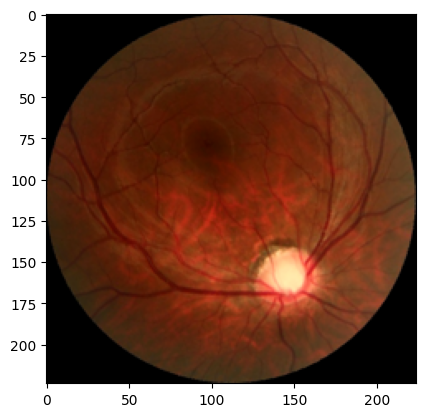

In [13]:
n_ = 111
temp_pth = image_list[n_]
print(temp_pth)
print(ground_truth_list[n_])
print(torch.round(nn.Softmax(dim=1)(model(image_loader(temp_pth).to(device))), decimals=3))

plt.imshow((image_loader(temp_pth))[0].permute(1, 2, 0))
image_loader(temp_pth).median().item()

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#model = HDREfficientNet().to(device)
#model.load_state_dict(torch.load("6_epochs", weights_only=True))
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.000004)
print(device)

cuda


In [20]:
# TRAINING LOOP

"""

>> TODO
 - Add diversity for D & N values per epoch (and H once we get more samples)
 - Actually get the model to classify N
 - Train, Validation, Testing Loop

"""

model.train()
epochs = 30
batch = 8
data_list = []
j = 0

for i in range(0, len(image_list)):
    data_list.append(i)


# TRAIN & TEST LOOP
for epoch in range (epochs):
    epoch_loss = 0
    count = 0
    random.shuffle(data_list)
    torch.save(model.state_dict(), str(epoch) + "_epochs")
    
    
    # TRAIN
    pred_true = 0
    N_N, N_D, N_H, D_N, D_D, D_H, H_N, H_D, H_H = [0]*9
    model.train()
    
    for i in range(0, len(image_list), batch):
        
        # TRAIN
        x = []
        y = []
        
        for k in range(0, batch):
            x.append(image_list[data_list[j % len(image_list)]])
            y.append(ground_truth_list[data_list[j % len(image_list)]])
            j += 1

        train_x, train_y = batch_loader(x, y)
        train_x = train_x.to(device)
        train_y = train_y.to(device).float()
        
        if train_x.shape != torch.Size([0, 3, 256, 256]):
            
            count += batch
            optimizer.zero_grad()
            predict_y = model(train_x)
            loss = loss_fn(predict_y, train_y)
            loss.backward()
            epoch_loss += float(loss)
            optimizer.step()
            
            for b in range(0, batch):
                if (torch.argmax(train_y[b]).item() == torch.argmax(predict_y[b])).item():
                    pred_true += 1
                    if torch.argmax(predict_y[b]).item() == 0:
                        N_N += 1
                    elif torch.argmax(predict_y[b]).item() == 1:
                        D_D += 1
                    else:
                        H_H += 1

                else:
                    if torch.argmax(train_y[b]).item() == 0:
                        if torch.argmax(predict_y[b]).item() == 1:
                            N_D += 1
                        else:
                            N_H += 1

                    elif torch.argmax(train_y[b]).item() == 1:
                        if torch.argmax(predict_y[b]).item() == 0:
                            D_N += 1
                        else:
                            D_H += 1

                    else:
                        if torch.argmax(predict_y[b]).item() == 0:
                            H_N += 1
                        else:
                            H_D += 1
                        
            if count % 4000 == 0:
                print("-", loss.item())
            #print(N_N, N_D, N_H)
            #print(D_N, D_D, D_H)
            #print(H_N, H_D, H_H)


    # Train Results
    print(epoch+1, ")", round(epoch_loss / (count/batch), 4))
    print((pred_true / count))
    print(N_N, N_D, N_H)
    print(D_N, D_D, D_H)
    print(H_N, H_D, H_H)
            
    
    # EVALUATION
    pred_true = 0
    N_N, N_D, N_H, D_N, D_D, D_H, H_N, H_D, H_H = [0]*9
    model.eval()
    
    for i in range(0, len(test_image_list)):
        train_x, train_y = batch_loader(test_image_list[i:i+1], test_ground_truth_list[i:i+1])
        train_x = train_x.to(device)
        train_y = train_y.to(device).float()
        predict_y = model(train_x)
        
        if train_x.shape != torch.Size([0, 3, 256, 256]):
        
            if (torch.argmax(train_y).item() == torch.argmax(predict_y)).item():
                pred_true += 1
                if torch.argmax(predict_y).item() == 0:
                    N_N += 1
                elif torch.argmax(predict_y).item() == 1:
                    D_D += 1
                else:
                    H_H += 1

            else:
                if torch.argmax(train_y).item() == 0:
                    if torch.argmax(predict_y).item() == 1:
                        N_D += 1
                    else:
                        N_H += 1
                        
                elif torch.argmax(train_y).item() == 1:
                    if torch.argmax(predict_y).item() == 0:
                        D_N += 1
                    else:
                        D_H += 1
                        
                else:
                    if torch.argmax(predict_y).item() == 0:
                        H_N += 1
                    else:
                        H_D += 1
    
    # Test Results
    print((pred_true / len(test_image_list)))
    print(N_N, N_D, N_H)
    print(D_N, D_D, D_H)
    print(H_N, H_D, H_H)
    print("")


- 0.8798282742500305
- 0.6363341808319092
- 0.8237889409065247
- 0.37143170833587646
1 ) 0.6982
0.6917162698412699
3251 935 1190
1060 4054 262
1387 138 3851
0.7663690476190477
758 217 369
154 1172 18
159 25 1160

- 0.3529689908027649
- 0.7502253651618958
- 0.2730443775653839
- 0.2332221120595932
2 ) 0.5004
0.7902405753968254
3624 845 907
669 4626 81
831 50 4495
0.8380456349206349
931 141 272
120 1213 11
109 0 1235

- 0.24142396450042725
- 0.27934715151786804
- 0.32970938086509705
- 0.42382699251174927
3 ) 0.3888
0.8447420634920635
3893 720 763
439 4892 45
492 45 4839
0.8663194444444444
949 233 162
63 1279 2
57 22 1265

- 0.19467821717262268
- 0.13766339421272278
- 0.4895757734775543
- 0.13800960779190063
4 ) 0.327
0.8760540674603174
4066 665 645
308 5027 41
316 24 5036
0.8975694444444444
1093 128 123
102 1242 0
43 17 1284

- 0.28412699699401855
- 0.08995326608419418
- 0.2178812325000763
- 0.4195597171783447
5 ) 0.2829
0.8943452380952381
4197 596 583
269 5092 15
223 18 5135
0.9007936507

In [14]:
# Load Model
model.load_state_dict(torch.load('13_epochs', map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))

<All keys matched successfully>

In [15]:
# AUC
from sklearn.metrics import roc_auc_score

# Set the model to evaluation mode
model.eval()

all_labels = []
all_probs = []

with torch.no_grad():  # No gradient computation
    
    for i in range(0, len(test_image_list)):
        inputs, labels = batch_loader(test_image_list[i:i+1], test_ground_truth_list[i:i+1])
        inputs = inputs.to(device)
        labels = labels.to(device).float()
        outputs = model(inputs)
        
        # Forward pass
        outputs = model(inputs)
        
        # Apply softmax to get probabilities for each class
        probs = torch.softmax(outputs, dim=1)
        
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert lists to numpy arrays for sklearn compatibility
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Calculate multi-class AUC
# Set `average="macro"` for macro average, or `average="weighted"` for weighted average
try:
    auc_score = roc_auc_score(all_labels, all_probs, multi_class="ovr", average="macro")
    print(f"Multi-class AUC Score: {auc_score}")
except ValueError as e:
    print(f"Error calculating AUC: {e}")


Multi-class AUC Score: 0.9828143822633219


In [ ]:
nn.Softmax(dim=1)(torch.randn(2, 3))

In [ ]:
train_x.shape